<a href="https://colab.research.google.com/github/rajdeepd/bpb-vector-databases/blob/main/chapter2/mnist_encoder_decoder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.15

In [1]:
from tensorflow import keras
import keras.layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from tensorflow import keras

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import losses
from scipy.stats import norm

In [4]:
import tensorflow
print(tensorflow.__version__)

2.15.0


In [5]:
(x_tr, y_tr), (x_te, y_te)  = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
len(x_tr)

60000

In [7]:
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [8]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [9]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

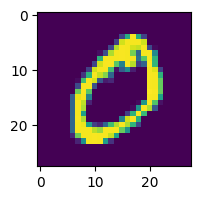

In [10]:
# Example of a training image
plt.figure(figsize = (2,2))
plt.imshow(x_tr[1]);

In [11]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps


### Sample text from another code
#### Encoder

```python
# Encoder - from 784->256->128->2
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer



# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])
```
### Decoder function
#### Decoder
```python
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)
```


In [13]:
shape = x_te.shape[1:]
#tf.math.reduce_prod(shape)

In [14]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer


# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)

decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")


outputs_flat = decoder_flat(z_flat)


In [16]:
# variational autoencoder (VAE) - to reconstruct input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss


# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [17]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 18s 25ms/step - loss: 199.6658 - val_loss: 170.7540
Epoch 2/50
600/600 [==============================] - 9s 15ms/step - loss: 165.9081 - val_loss: 162.2400
Epoch 3/50
600/600 [==============================] - 7s 12ms/step - loss: 160.2623 - val_loss: 158.4466
Epoch 4/50
600/600 [==============================] - 8s 14ms/step - loss: 156.6190 - val_loss: 154.9251
Epoch 5/50
600/600 [==============================] - 8s 14ms/step - loss: 153.5682 - val_loss: 152.2999
Epoch 6/50
600/600 [==============================] - 7s 12ms/step - loss: 151.4314 - val_loss: 150.3394
Epoch 7/50
600/600 [==============================] - 8s 14ms/step - loss: 149.6510 - val_loss: 149.0634
Epoch 8/50
600/600 [==============================] - 8s 13ms/step - loss: 148.1997 - val_loss: 147.5491
Epoch 9/50
600/600 [==============================] - 8s 13ms/step - loss: 146.9791 - val_loss: 146.5393
Epoch 10/50
600/600 [==============================] -

In [39]:
encoded_imgs = autoencoder.encoder(x_te).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

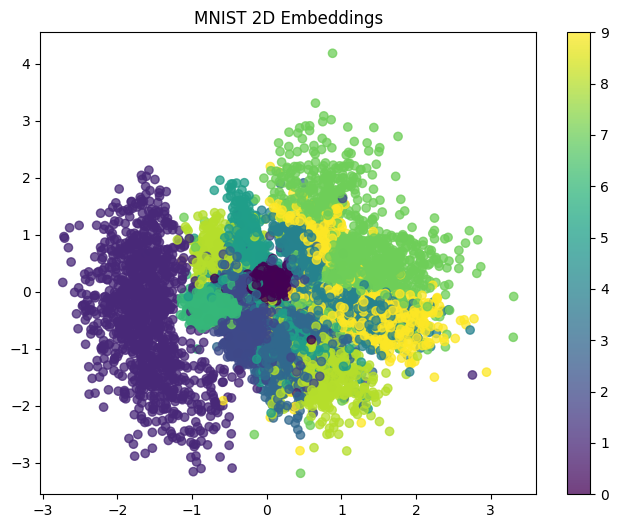

In [20]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder


# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()


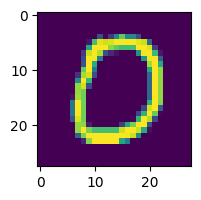

In [25]:
plt.figure(figsize = (2,2))
plt.imshow(x_te_flat[10].reshape(28,28));

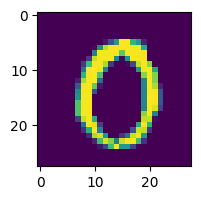

In [27]:
plt.figure(figsize = (2,2))
plt.imshow(x_te_flat[13].reshape(28,28));

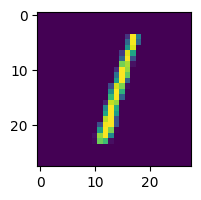

In [28]:
plt.figure(figsize = (2,2))
plt.imshow(x_te_flat[2].reshape(28,28));

In [29]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]


print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [0.00667779 0.03344763]
Embedding for the second ZERO is [-0.06528544 -0.05125995]
Embedding for the ONE is         [-2.3119102  -0.06895111]
